In [1]:
import matplotlib
import numpy as np
import psutil
import ray
import os
import seaborn as sns
import time

import matplotlib.pyplot as plt
import numpy.linalg as la

sns.set(style="whitegrid", context="talk", font_scale=1.2, palette=sns.color_palette("bright"), color_codes=False)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'DejaVu Sans'
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['figure.figsize'] = (9, 6)

In [2]:
iterations = 800
num_workers = 40
it_check = 40 #
n_seeds = 5 #
max_seed = 424242 #
rng = np.random.default_rng(42)

seeds = rng.choice(max_seed, size=n_seeds, replace=False) # seeds 里的随机种子是不相同

n_data = 10000
dim = 400
batch_size = 256
noise_scale = 1e-1
A = rng.uniform(size=(n_data, dim)) / np.sqrt(dim)
x_rand = rng.normal(size=dim)
b = A @ x_rand + noise_scale * rng.normal(size=n_data)

In [3]:
@ray.remote
class ParameterServer(object):
    def __init__(self, lr, asynchronous, num_workers=0):
        self.x = np.zeros(dim)
        self.lr = lr
        self.asynchronous = asynchronous
        self.gradient_cache = [np.zeros(dim) for _ in range(num_workers)]

    def apply_gradients(self, grad, *gradients):
        # *把一串位置参数打包到一个元组里
        if self.asynchronous:
            self.x -= self.lr * grad
        else:
            summed_gradients = np.sum(gradients, axis=0)
            self.x -= self.lr * summed_gradients
        return self.x

    def apply_cached_gradients(self, worker_id, grad):
        self.gradient_cache[worker_id] = grad
        summed_gradients = np.sum(self.gradient_cache, axis=0)
        self.x -= self.lr * summed_gradients
        return self.x

    def get_x(self):
        return self.x
    
    def update_lr(self, lr_new=None):
        if lr_new is not None:
            self.lr = lr_new


    def get_hyperparams(self):
        return self.lr, self.asynchronous

In [4]:
def grad_func(x):
    return (A@x - b) @ A / n_data

def sgrad_func(rng, x):
    i = rng.integers(n_data)
    return (A[i]@x - b[i]) * A[i]

def batch_grad_func(rng, x, batch_size):
    idx = rng.choice(n_data, size=batch_size, replace=False)
    return (A[idx]@x - b[idx]) @ A[idx] / batch_size

@ray.remote
class DataWorker(object):
    """
    The class for an individual Ray worker.
    Arguments:
        lr (float): the stepsize to be used at initialization
        label (int, optional): batch size for sampling gradients (default: 1)
        seed (int, optional): random seed to generate random variables for reproducibility (default: 0)
        bad_worker (bool, optional): if True, the worker will be forced to be slower than others (default: False)
    """
    def __init__(self, lr, batch_size=1, seed=0):
        self.lr = lr
        self.batch_size = batch_size
        self.rng = np.random.default_rng(seed)

    def compute_gradients(self, x):
        t0 = time.perf_counter()
        if self.batch_size is None:
            grad = grad_func(x)
        elif self.batch_size == 1:
            grad = sgrad_func(self.rng, x)
        else:
            grad = batch_grad_func(self.rng, x, self.batch_size)
        return grad
    
        
    def get_hyperparams(self):
        return self.lr, self.batch_size
    
    def get_lr(self):
        return self.lr

In [5]:
def evaluate(x):
    assert len(x) == dim
    return 0.5 * np.mean((A @ x - b)**2)

In [6]:
def run_single_worker_sgd(lr, iterations, batch_size, it_check):
    """
    Runs a single-worker (pure) minibatch SGD.
    """
    rng = np.random.default_rng(42)
    x = np.zeros(dim)
    
    trace = []
    its = []
    ts = []
    t0 = time.perf_counter()
    
    for it in range(iterations):
        # Calculate gradient on a large batch
        grad = batch_grad_func(rng, x, batch_size)
        
        # Update model
        x -= lr * grad
        
        if it % it_check == 0:
            trace.append(x.copy())
            its.append(it)
            ts.append(time.perf_counter() - t0)
            
    return np.asarray(its), np.asarray(ts), np.asarray([evaluate(x) for x in trace])

In [7]:
def run(num_workers, lr, lr_decay=0, iterations=200, asynchronous=True, delay_adaptive=False, it_check=20,
        batch_size=1, async_cached=False):
    delays_all = []
    worker_updates = [0 for i in range(num_workers)]
    rng = np.random.default_rng(42)
    seeds_workers = rng.choice(max_seed, size=num_workers, replace=False)
    # seeds_workers = [rng.choice(max_seed, size=1, replace=False)[0] for _ in range(num_workers)]
    ray.init(ignore_reinit_error=True)
    ps = ParameterServer.remote(lr, asynchronous, num_workers=num_workers if async_cached else 0)
    workers = [DataWorker.remote(lr=lr, batch_size=batch_size, seed=seeds_workers[i]) for i in range(num_workers)]

    x = ps.get_x.remote()
    if asynchronous:
        gradients = {}
        worker_last_it = [0 for _ in range(num_workers)]
        worker_id_to_num = {}
        for e, worker in enumerate(workers):
            gradients[worker.compute_gradients.remote(x)] = worker
            worker_id_to_num[worker] = e


    losses = []
    its = []
    ts = []
    delays = []
    t0 = time.perf_counter()
    delay = 0
    trace = []
    grads_per_it = 1 if asynchronous else num_workers

    for it in range(iterations * (num_workers if asynchronous else 1)):
        n_grads = it * grads_per_it
        if asynchronous:
            ready_gradient_list, _ = ray.wait(list(gradients))
            ready_gradient_id = ready_gradient_list[-1]
            worker = gradients.pop(ready_gradient_id)
            grad = ray.get(ready_gradient_id)

            # Compute and apply gradients.
            gradients[worker.compute_gradients.remote(x)] = worker
            worker_num = worker_id_to_num[worker]
            delay = it - worker_last_it[worker_num]
            if delay_adaptive:
                lr_new = lr * num_workers / max(num_workers, delay)
                ps.update_lr.remote(lr_new=lr_new)
            
            if async_cached:
                x = ps.apply_cached_gradients.remote(worker_num, grad)
            else:
                x = ps.apply_gradients.remote(grad=grad)

            worker_last_it[worker_num] = it
            worker_updates[worker_num] += 1
        else:
            gradients = [
                worker.compute_gradients.remote(x) for worker in workers
            ]
            # Calculate update after all gradients are available.
            x = ps.apply_gradients.remote(None, *gradients)

        if it % it_check == 0 or (not asynchronous and it % (max(it_check // num_workers, 1)) == 0):
            # Evaluate the current model.
            x = ray.get(ps.get_x.remote())
            trace.append(x.copy())
            its.append(it)
            ts.append(time.perf_counter() - t0)

        lr_new = lr / (1 + lr_decay * n_grads)
        ps.update_lr.remote(lr_new=lr_new)
        t = time.perf_counter()
        if asynchronous:
            delays.append(delay)

    ray.shutdown()
    return np.asarray(its), np.asarray(ts), np.asarray([evaluate(x) for x in trace]), np.asarray(delays)

## Parameters

In [8]:
psutil.cpu_count(logical=True)

152

In [9]:
x_opt, _, _, _ = np.linalg.lstsq(A, b)
f_min = evaluate(x_opt)

## Synchronous

In [10]:
lr_mini = 0.19 # best tuned with aggregate gradient Aggregated gradient (not averaged)
# lr_mini = 8 # best tuned with aggregate gradient Aggregated gradient (averaged)
lr_decay = 0
its_, ts_, losses_, _ = run(num_workers, lr=lr_mini,  iterations=iterations,
                            asynchronous=False, delay_adaptive=False, it_check=it_check, batch_size=batch_size)

2025-11-19 04:42:38,654	INFO worker.py:2003 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
/home/cipher/miniconda3/envs/async/lib/python3.11/site-packages/ray/_private/worker.py:2051: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(
/home/cipher/miniconda3/envs/async/lib/python3.11/site-packages/ray/_private/worker.py:2051: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(


(raylet) Warning: The actor DataWorker is very large (30 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


In [11]:
# Run "pure" single-worker minibatch SGD
# To ensure a fair comparison on gradient computations, we run it for more iterations.
# Async SGD runs for `iterations * num_workers` gradient steps.
# Sync SGD runs for `iterations` steps, but each step uses `num_workers` gradients.
# So, the total number of gradients computed is `iterations * num_workers`.
lr_single = 0.43 
iterations_single = iterations * num_workers 
it_check_single = it_check * num_workers # Adjust check frequency to be comparable

its_single, ts_single, losses_single = run_single_worker_sgd(
    lr=lr_single, 
    iterations=iterations_single, 
    it_check=it_check_single, 
    batch_size=batch_size
)

In [12]:
lr_as = 0.43 # best tuned
lr_decay = 0
its_as, ts_as, losses_as, _ = run(num_workers, lr=lr_as,
                                  iterations=iterations, asynchronous=True, delay_adaptive=False, 
                                  it_check=it_check, batch_size=batch_size)

2025-11-19 04:43:24,503	INFO worker.py:2003 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


(raylet) Warning: The actor DataWorker is very large (30 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


In [13]:
lr_ad = 0.43 # best tuned
lr_decay = 0
its_ad, ts_ad, losses_ad, delays = run(num_workers, lr=lr_ad,
                                       iterations=iterations, asynchronous=True, delay_adaptive=True, 
                                       it_check=it_check, batch_size=batch_size)

2025-11-19 04:44:11,811	INFO worker.py:2003 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


(raylet) Warning: The actor DataWorker is very large (30 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


In [14]:
lr_ac = 0.001 # best tuned
lr_decay = 0
its_ac, ts_ac, losses_ac, _ = run(num_workers, lr=lr_ac,
                                       iterations=iterations, asynchronous=True, delay_adaptive=False, 
                                       it_check=it_check, batch_size=batch_size, async_cached=True)

2025-11-19 04:44:59,833	INFO worker.py:2003 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


(raylet) Warning: The actor DataWorker is very large (30 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


Text(0, 0.5, '$F(\\mathbf{x}) - F^*$')

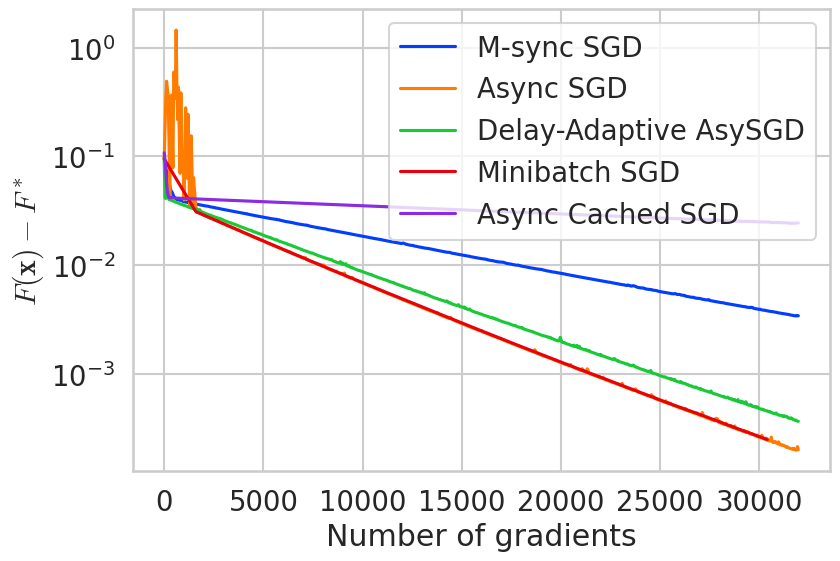

In [15]:
plt.plot(its_ * num_workers, losses_ - f_min, label='M-sync SGD')
plt.plot(its_as, losses_as - f_min, label='Async SGD')
plt.plot(its_ad, losses_ad - f_min, label='Delay-Adaptive AsySGD')
plt.plot(its_single, losses_single - f_min, label='Minibatch SGD')
plt.plot(its_ac, losses_ac - f_min, label='Async Cached SGD')
plt.yscale('log')
plt.legend()
plt.xlabel('Number of gradients')
plt.ylabel(r'$F(\mathbf{x}) - F^*$')
# plt.savefig(f'quadratic_grads_M_{num_workers}_n={n_data}_dim={dim}_bs_{batch_size}.pdf', bbox_inches='tight')

Text(0, 0.5, '$F(\\mathbf{x}) - F^*$')

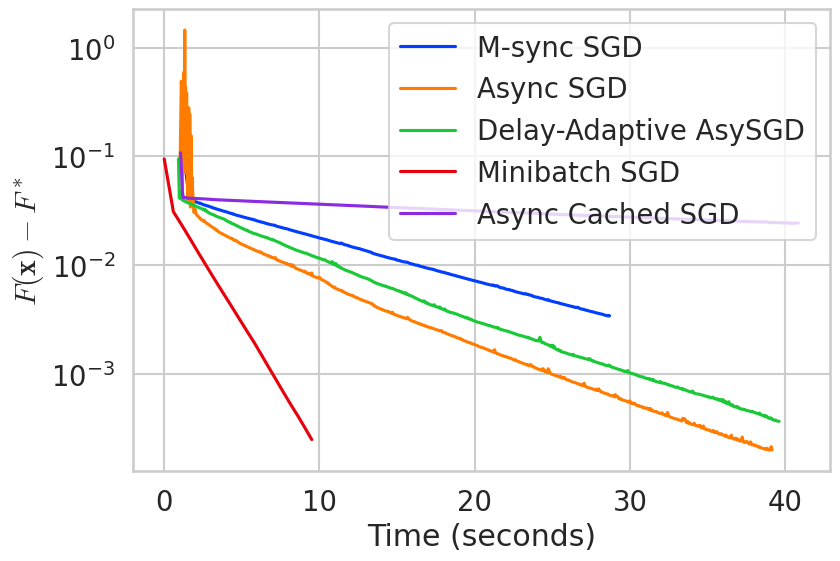

In [16]:
plt.plot(ts_, losses_ - f_min, label='M-sync SGD')
plt.plot(ts_as, losses_as - f_min, label='Async SGD')
plt.plot(ts_ad, losses_ad - f_min, label='Delay-Adaptive AsySGD')
plt.plot(ts_single, losses_single - f_min, label='Minibatch SGD')
plt.plot(ts_ac, losses_ac - f_min, label='Async Cached SGD')
plt.yscale('log')
plt.legend()
plt.xlabel('Time (seconds)')
plt.ylabel(r'$F(\mathbf{x}) - F^*$')
# plt.savefig(f'quadratic_grads_M_{num_workers}_n={n_data}_dim={dim}_bs_{batch_size}.pdf', bbox_inches='tight')

Text(0, 0.5, '$F(\\mathbf{x}) - F^*$')

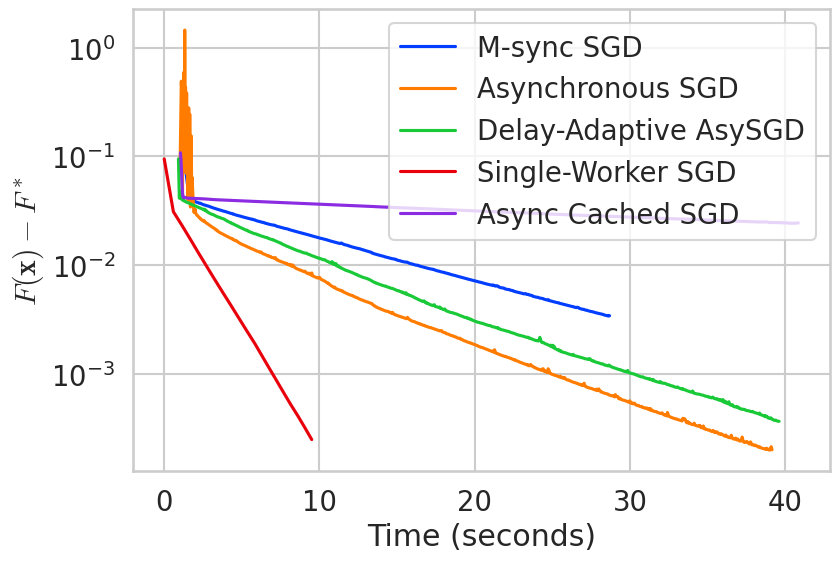

In [17]:
plt.plot(ts_, losses_ - f_min, label='M-sync SGD')
plt.plot(ts_as, losses_as - f_min, label='Asynchronous SGD')
plt.plot(ts_ad, losses_ad - f_min, label='Delay-Adaptive AsySGD')
plt.plot(ts_single, losses_single - f_min, label='Single-Worker SGD') # Add this line
plt.plot(ts_ac, losses_ac - f_min, label='Async Cached SGD')
plt.yscale('log')
plt.legend()
plt.xlabel('Time (seconds)')
plt.ylabel(r'$F(\mathbf{x}) - F^*$')
# plt.savefig(f'quadratic_time_M_{num_workers}_n={n_data}_dim={dim}_bs_{batch_size}.pdf', bbox_inches='tight')

In [18]:
# Run the new "Async Cached SGD"
lr_ac = 1e-4 
its_ac, ts_ac, losses_ac, delays_ac = run(
    num_workers=num_workers,
    lr=lr_ac,
    iterations=iterations,
    asynchronous=True,
    async_cached=True,
    it_check=it_check,
    batch_size=batch_size
)

2025-11-19 04:45:50,360	INFO worker.py:2003 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


(raylet) Warning: The actor DataWorker is very large (30 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


Text(0, 0.5, '$F(\\mathbf{x}) - F^*$')

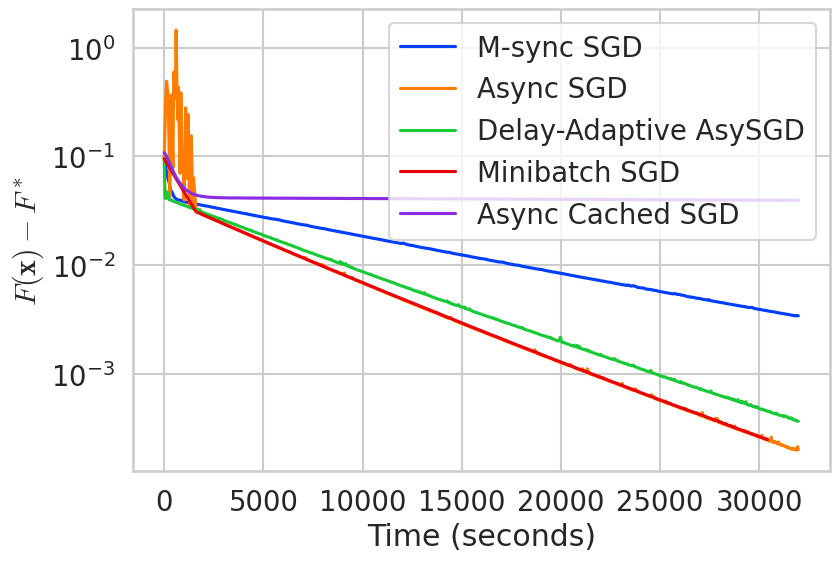

In [19]:
plt.figure()
plt.plot(its_*num_workers, losses_ - f_min, label='M-sync SGD')
plt.plot(its_as, losses_as - f_min, label='Async SGD')
plt.plot(its_ad, losses_ad - f_min, label='Delay-Adaptive AsySGD')
plt.plot(its_single, losses_single - f_min, label='Minibatch SGD')
plt.plot(its_ac, losses_ac - f_min, label='Async Cached SGD')
plt.yscale('log')
plt.legend()
plt.xlabel('Time (seconds)')
plt.ylabel(r'$F(\mathbf{x}) - F^*$')
# plt.savefig(f'quadratic_time_M_{num_workers}_n={n_data}_dim={dim}_bs_{batch_size}.pdf', bbox_inches='tight')